Importing basic functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Loading the data and looking at the first few rows

In [2]:
full = pd.read_csv('./dotplot/IL-clean.csv',low_memory = False)
full.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,stop_duration,vehicle_type,drugs_related_stop,district
0,IL-2004-000001,IL,2004-01-01,00:02,ILLINOIS STATE POLICE 17,NaN,NaN,17,Illinois State Police,F,...,False,NaN,NaN,False,Written Warning,NaN,NaN,Olds 2000,NaN,ILLINOIS STATE POLICE 17
1,IL-2004-000002,IL,2004-01-01,00:07,ILLINOIS STATE POLICE 07,NaN,NaN,07,Illinois State Police,M,...,False,NaN,NaN,False,Written Warning,NaN,NaN,Linc 1990,NaN,ILLINOIS STATE POLICE 07
2,IL-2004-000003,IL,2004-01-01,00:14,ILLINOIS STATE POLICE 11,NaN,NaN,11,Illinois State Police,M,...,False,NaN,NaN,False,Citation,NaN,NaN,Chev 1996,NaN,ILLINOIS STATE POLICE 11
3,IL-2004-000004,IL,2004-01-01,00:15,ILLINOIS STATE POLICE 03,Cook County,17031.0,03,Illinois State Police,F,...,False,NaN,NaN,False,Citation,NaN,NaN,Buic 1992,NaN,ILLINOIS STATE POLICE 03
4,IL-2004-000005,IL,2004-01-01,00:15,ILLINOIS STATE POLICE 09,NaN,NaN,09,Illinois State Police,F,...,False,NaN,NaN,False,Citation,NaN,NaN,Olds 1996,NaN,ILLINOIS STATE POLICE 09


We're interesting in how often police officers stop people (n_stops), how often those people are searched (n_searches), how often those searches find contraband (n_hits), as well the relevant ratios of those terms (search_rate = n_stops / n_searches, hit_rate = n_hits / n_searches). This function takes in the data and outputs these results as a dataframe. Notably, we can filter the input data such that the function will tell us these statistics under certain conditions (such as time of day) or for certain groups.

In [3]:
def SummaryStats(df,label):
    # given an input dataframe of policing data, it will return a dataframe with its overall stats summarized 
    # with the index 'label'
    n_stops = df.shape[0]
    n_searches = df['search_conducted'].sum()
    n_hits = df['contraband_found'].sum()
    search_rate = n_searches / n_stops
    hit_rate = n_hits / n_searches
    td={'n_stops' : n_stops, 'n_searches' : n_searches, 'n_hits' : n_hits, 'search_rate' : search_rate,'hit_rate' : hit_rate}
    return pd.DataFrame(data=td,index=[label],columns=['n_stops','n_searches','n_hits','search_rate','hit_rate'])

We'll begin by looking at how police operate at different times of the day. To accomplish this, we first need to make the times in the dataframe readable. We'll then use the function we just wrote to summarize police action at each hour of the day.

In [4]:
temptimes = full['stop_time'][:].str.slice(0,2) # extract the hour from the dataframe
times = pd.to_numeric(temptimes) # convert that hour into a number

df_columns=['n_stops','n_searches','n_hits','search_rate','hit_rate'] # the columns of our dataframes

time_data = pd.DataFrame(columns=df_columns) # initialize the dataframe

# make the relavent dataframe
for i in range(0,24):
    time_data=time_data.append(SummaryStats(full[times==i],i))

Let's start just by looking at overall police activity over the course of the day, how often they stop people and how often they search vehicles.

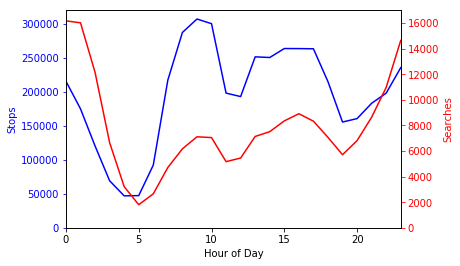

In [5]:
# initializing the plot
fig, ax1 = plt.subplots()

# plotting stops as a function of time
ax1.plot(time_data.index, time_data.n_stops, 'b-', label = 'stops')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Stops', color='b')
ax1.tick_params('y', colors='b')
ax1.axis([0,23,0,320000])

# plotting searches as a function of time
ax2 = ax1.twinx()
ax2.plot(time_data.index, time_data.n_searches, 'r-',label = 'searches')
ax2.set_ylabel('Searches', color = 'r')
ax2.tick_params('y', colors = 'r');
ax2.axis([0, 23, 0, 17000]);

plt.show()

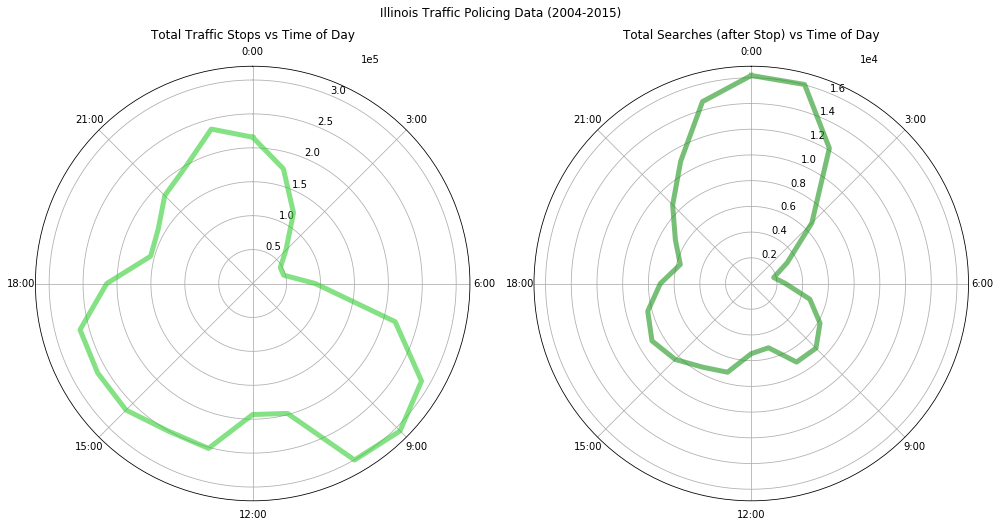

In [6]:
data = [time_data.n_stops, time_data.n_searches]
colors = ['#32CD32', '#1D951B']
super_title = 'Illinois Traffic Policing Data (2004-2015)'
titles = ['Total Traffic Stops vs Time of Day', 
          'Total Searches (after Stop) vs Time of Day']


def polar_time_lineplot(dat, colr, titl, super_title, nrow, ncol):
    """
    Creates a series of polar subplots to mimic a 24-hour clock (cyles back onto itself)
    dat -> list of y-data (can be list of arrays, Series, etc.)
    colr -> list of colors (should be same length as number of data arrays)
    titl -> list of titles (should be same length as number of data arrays)
    super_title -> title to go above subplots (describe data source, for ex.)
    nrow, ncol -> dimensions of subplots, (nrow) x (ncol) <= len(dat)
    """
    fig, axs = plt.subplots(nrow, ncol, 
                            figsize = (14, 8), subplot_kw=dict(projection='polar'))
    for i, ax in enumerate(fig.axes):
        # 'radian' array for time segements
        theta = np.linspace(0, 2 * np.pi, len(dat[i])+1)
        dat[i] = dat[i].append(pd.Series(dat[i][0])) # dup startpt for line continuous w/ endpt
        # plot
        ax.plot(theta, dat[i], linewidth=5.0, color=colr[i], alpha=0.6)
        # Polar clock formating
        ax.set_theta_zero_location("N") #0:00 at top ('north')
        ax.set_theta_direction(-1) #clockwise polarity
        ticks = ['0:00', '3:00', '6:00', '9:00', '12:00', '15:00', '18:00', '21:00']
        ax.set_xticklabels(ticks)
        # General formatting
        ax.yaxis.get_major_formatter().set_powerlimits((-2,4))
        ax.get_yaxis().get_offset_text().set_position([0.75, 0]) # hard-coded, not smart
        ax.set_title(titl[i])

    fig.tight_layout(h_pad=1)
    fig.suptitle(super_title)
    plt.show()
    
polar_time_lineplot(data, colors, titles, super_title, 1, 2)

In [7]:
[25, data[0].values[0]]

[25, 215690]

The results are generally inuitive, there aren't many stops early in the morning, although this picks up during the day with drops around lunch time and dinner. It is somewhat suprising that searches go way up late at night. Let's look at search rate and how often those searches are successful (hit rate) to see if that provides further insight. 

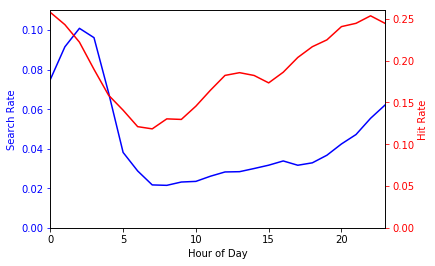

In [8]:
# initializing the plot
fig, ax1 = plt.subplots()

# plot search rate
ax1.plot(time_data.index, time_data.search_rate, 'b-',label = 'Search Rate')
ax1.set_ylabel('Search Rate', color = 'b')
ax1.tick_params('y', colors = 'b')
plt.xlabel('Hour of Day')
ax1.axis([0, 23, 0, .11])

# plot hit rate
ax2=ax1.twinx()
ax2.plot(time_data.index, time_data.hit_rate, 'r-',label = 'Hit Rate')
ax2.set_ylabel('Hit Rate', color = 'r')
ax2.tick_params('y', colors = 'r')
ax2.axis([0, 23, 0, .26]);

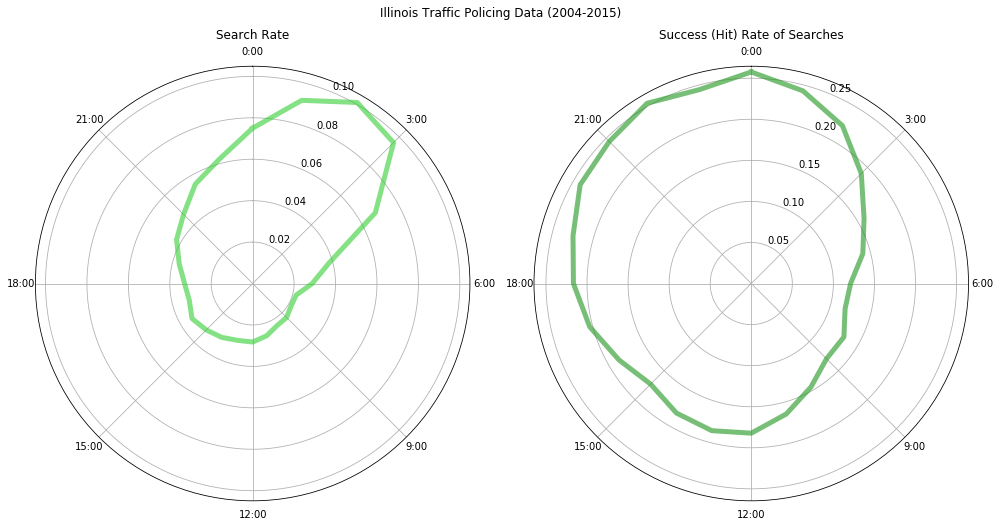

In [9]:
data = [time_data.search_rate, time_data.hit_rate]
colors = ['#32CD32', '#1D951B']
titles = ['Search Rate', 'Success (Hit) Rate of Searches']
polar_time_lineplot(data, colors, titles, super_title, 1, 2)

Both rates start low early in the morning (~ 6 am) and continue to rise during the day and late into the night until around 3 or 4 am in the morning when they return to their minima. It's worth noting that the search rate is not just determined by the police officer and shouldn't correlate with the hit rate. Presumably, police officers only search a vehicle when they have a reason to be suspicious and should have a more or less constant hit rate. If they are overly suspicious the hit rate should be lower and if the aren't suspicious enough the hit rate should be higher. Thus, even though the search rate is the lowest early in the morning, it should be even lower. This interpretation assumes people are equally good at concealing their contraband under all conditions. It may be possible that some people are tired at night and obviously have contraband, increasing the overall hit rate. To try to visualize this relationship better, we'll plot search rate vs hit rate, with marker size scaled for number of stops made.

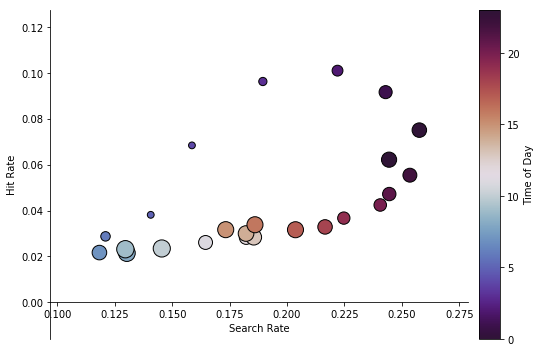

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
timeplot = plt.scatter(x=time_data.hit_rate, y=time_data.search_rate,c=time_data.index,
                       cmap=plt.cm.get_cmap('twilight_shifted'),
                       s=pd.to_numeric(time_data.n_stops / time_data.n_stops.max()) * 300,
                       alpha = 1.0, edgecolor='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_position(('zero'))
ax.axis('equal')
plt.xlabel('Search Rate')
plt.ylabel('Hit Rate')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(timeplot, cax=cax)
cbar.set_label('Time of Day')

plt.tight_layout(h_pad=1)
plt.show()

Now we'll look at the relationship of age and gender on highway policing. First we need to generate the data.

In [11]:
ages = pd.to_numeric(full['driver_age']) # extract the ages from the original dataframe

# initializing the dataframes
male_data = pd.DataFrame(columns = df_columns)
female_data = pd.DataFrame(columns = df_columns)

# filling in all of the data
for i in range(16,71):
    temp_data = full[ages==i]
    male_data = male_data.append(SummaryStats(temp_data[temp_data['driver_gender']=='M'], i))
    female_data = female_data.append(SummaryStats(temp_data[temp_data['driver_gender']=='F'], i))

Let's look at how often people are stopped by age and gender.

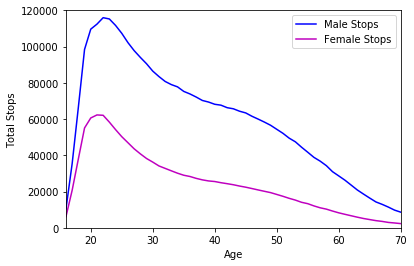

In [12]:
fig, ax = plt.subplots()
ax.plot(male_data.index, male_data.n_stops, 'b-',label = 'Male Stops')
ax.plot(female_data.index, female_data.n_stops, 'm-',label = 'Female Stops')
ax.set_ylabel('Total Stops')
ax.tick_params('y')
plt.xlabel('Age')
plt.legend()
plt.axis([16, 70, 0, 120000]);

The most obvious trend is that many more men are stopped than women at all ages. Also, more people in their twenties are stopped which decreases with age except for a slight plateau from the ages of 30-50. To compare age trends between genders, we'll need to normalize the data, which we do below.

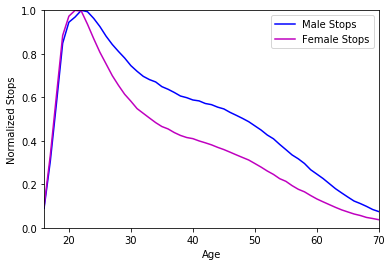

In [13]:
fig, ax = plt.subplots()
ax.plot(male_data.index, male_data.n_stops / male_data.n_stops.max(), 'b-',label = 'Male Stops')
ax.plot(female_data.index, female_data.n_stops / female_data.n_stops.max(), 'm-',label = 'Female Stops')
ax.set_ylabel('Normalized Stops')
ax.tick_params('y')
plt.xlabel('Age')
plt.legend()
plt.axis([16, 70, 0, 1]);

The plateua is at a relatively higher value for men. Let's see what searches look like.

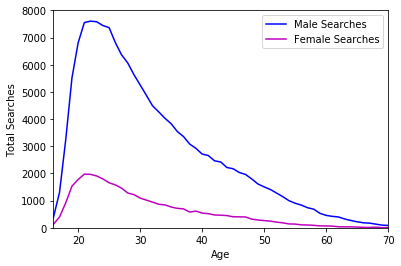

In [14]:
fig, ax = plt.subplots()
ax.plot(male_data.index, male_data.n_searches, 'b-',label = 'Male Searches')
ax.plot(female_data.index, female_data.n_searches, 'm-', label = 'Female Searches')
ax.set_ylabel('Total Searches')
ax.tick_params('y')
plt.xlabel('Age')
plt.legend()
plt.axis([16, 70, 0, 8000]);

Unsuprisingly, these trends mirror the total stops data. Let's look at search rate.

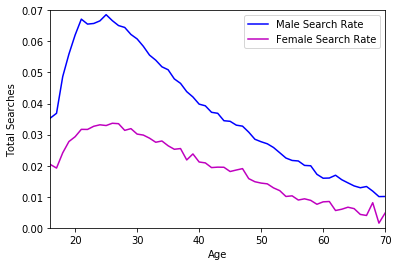

In [15]:
fig, ax = plt.subplots()
ax.plot(male_data.index, male_data.search_rate, 'b-',label = 'Male Search Rate')
ax.plot(female_data.index, female_data.search_rate, 'm-',label = 'Female Search Rate')
ax.set_ylabel('Total Searches')
ax.tick_params('y')
plt.xlabel('Age')
plt.legend()
plt.axis([16, 70, 0, .07]);

The search rate is higher for men. Further, the increases from teenagers to people in their early twenties, and then decreases with age. We can check for bias by examining the hit rate. Let's start with men.

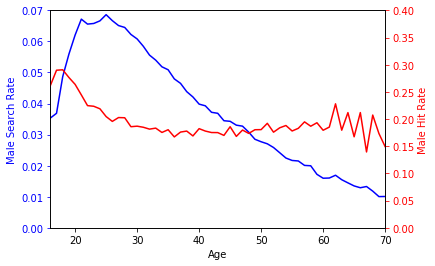

In [16]:
# initializing the plot
fig, ax1 = plt.subplots()

# plotting the search rate
ax1.plot(male_data.index, male_data.search_rate, 'b-', label = 'Search Rate')
ax1.set_ylabel('Male Search Rate', color = 'b')
ax1.tick_params('y', colors = 'b')
ax1.axis([16, 80, 0, .07])

# plotting the hit rate
plt.xlabel('Age')
ax2=ax1.twinx()
ax2.plot(male_data.index, male_data.hit_rate, 'r-', label = 'Hit Rate')
ax2.set_ylabel('Male Hit Rate', color = 'r')
ax2.tick_params('y', colors = 'r')
ax2.axis([16, 70, 0, .4]);

The hit rate is actually fairly consistent across people of all ages. It seems like police are a bit hesitant to search younger people (or some younger people are worse at concealing contraband). There are also fewer stops/searches of older people, resulting in worse statistics and the larger apparent variations. Let's examine women.

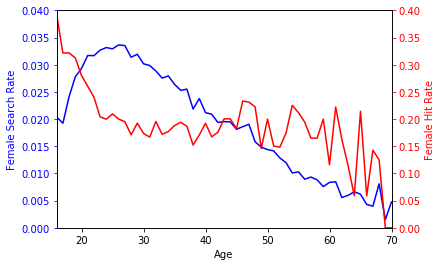

In [17]:
# initializing the plots
fig, ax1 = plt.subplots()

# plotting search rate
ax1.plot(female_data.index, female_data.search_rate, 'b-', label = 'Search Rate')
ax1.set_ylabel('Female Search Rate', color = 'b')
ax1.tick_params('y', colors = 'b')
plt.xlabel('Age')
ax1.axis([16, 70, 0, .04])

# plotting hit rate
ax2=ax1.twinx()
ax2.plot(female_data.index, female_data.hit_rate, 'r-', label = 'Hit Rate')
ax2.set_ylabel('Female Hit Rate', color='r')
ax2.tick_params('y', colors='r')
ax2.axis([16, 70, 0, .4]);

We observe basically the same trends as we saw with men but with worse statistics. We'll visualize it with search rate vs hit rate again.

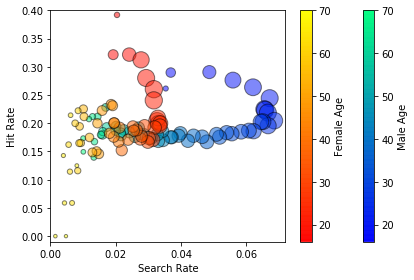

In [18]:
# initialize the plot
fig1, ax = plt.subplots()

# plot the male data
male_plot = plt.scatter(x = male_data.search_rate, 
                        y = male_data.hit_rate, 
                        c = male_data.index, 
                        cmap = plt.cm.get_cmap('winter'),
                        edgecolor = 'k', alpha = 0.5,
                        s = pd.to_numeric(male_data.n_stops / 
                                          male_data.n_stops.max()) * 300)
mcbar = plt.colorbar(male_plot)
mcbar.solids.set_edgecolor("face")
mcbar.set_label('Male Age')

# plot the female data
female_plot = plt.scatter(x = female_data.search_rate, 
                          y = female_data.hit_rate, 
                          c=female_data.index,
                          cmap = plt.cm.get_cmap('autumn'),
                          edgecolor = 'k', alpha = 0.5,
                          s = pd.to_numeric(female_data.n_stops / 
                                            female_data.n_stops.max()) * 300)
fcbar = plt.colorbar(female_plot )
fcbar.solids.set_edgecolor("face")
fcbar.set_label('Female Age')

# making the plot look better
plt.xlabel('Search Rate')
plt.axis([0, .072, -0.01, .4])
plt.ylabel('Hit Rate');

plt.tight_layout(h_pad=1)
plt.show()

Finally, let's examine the role of race in all of this. We begin by compiling overall statistics.

In [19]:
# initialize the dataframe
SummarizedStops = pd.DataFrame(columns = df_columns)

# start with overall statistics
SummarizedStops = SummarizedStops.append(SummaryStats(full, 'All Stops'))

# examine specific races
for race in full['driver_race'].unique():
    temp = SummaryStats(full[full['driver_race']==race], race + ' Stops')
    SummarizedStops = SummarizedStops.append(temp)    
    
# display the results    
SummarizedStops

,n_stops,n_searches,n_hits,search_rate,hit_rate
All Stops,4715031,188728,38733,0.040027,0.205232
White Stops,3437483,89166,21865,0.025939,0.245217
Black Stops,796114,64810,12507,0.081408,0.192979
Hispanic Stops,360294,31877,3977,0.088475,0.124761
Asian Stops,111758,2562,339,0.022925,0.132319
Other Stops,9382,313,45,0.033362,0.143770


Non-whites have lower than average hit rates (hispanics almost by a factor of two), with black and hispanic people having extremely high search rates. To examine how important race is in police interactions, we can compare it to the previous trends we've plotted. The size of the racial points will all be the same (they won't depend on the number of searches performed).

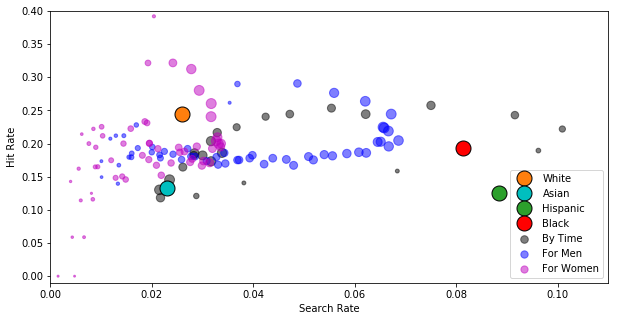

In [20]:
# initialize the figure
plt.figure(figsize = (10, 5))

race_data = [SummarizedStops['search_rate'], SummarizedStops['hit_rate']]
col_list = ['tab:orange','r','tab:green','c']
race_list = ['White', 'Black', 'Hispanic', 'Asian']


# plot the earlier data
plt.scatter(x = time_data.search_rate, y = time_data.hit_rate, c = 'k',
            s=pd.to_numeric(time_data.n_stops / time_data.n_stops.max()) * 100, 
            label = 'By Time', alpha = 0.5)
plt.scatter(x = male_data.search_rate, y = male_data.hit_rate, c = 'b', 
            s = pd.to_numeric(male_data.n_stops / male_data.n_stops.max()) * 100, 
            label = 'For Men', alpha = 0.5)
plt.scatter(x = female_data.search_rate, y = female_data.hit_rate, c = 'm',
            s = pd.to_numeric(female_data.n_stops / female_data.n_stops.max()) * 100, 
            label = 'For Women', alpha = 0.5)

# plot racial data
for i in [0, 3, 2, 1]:
    plt.plot(race_data[0][i+1], race_data[1][i+1], marker = 'o',
             linestyle = '', label = race_list[i], 
             color = col_list[i], markersize = 15, markeredgecolor = 'k')

# make the plot look better
plt.xlabel('Search Rate')
plt.ylabel('Hit Rate')
plt.legend(loc='best')
plt.tight_layout(h_pad=1)
plt.axis([0, .11, -0.01, .4]);

To demonstrate that this is not due to where people live, we'll calculate these stats based on police district.

In [21]:
# initialize the dataframe and stats
LocationStops = pd.DataFrame(columns=['race','district_number','n_stops','n_searches','n_hits','search_rate','Overall_search_rate','hit_rate','Overall_hit_rate'])
tot_stops = []
tot_searches = []

# set the districts and races we will look at
districts = ['01','02','03','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22']
races = ['White','Black','Hispanic','Asian']

for i in districts:
    district = 'ILLINOIS STATE POLICE ' + i # get the district string
    
    # get the district data
    district_data = full[(full['district']==district)]
    
    # get general stats about that district
    overall = SummaryStats(district_data, i)
    #overallhit = overall.get_value(overall.index[0], 'hit_rate')
    overallhit = overall.at[overall.index[0], 'hit_rate']
    overallsearch = overall.at[overall.index[0], 'search_rate']
    tot_stops.append(overall.at[overall.index[0], 'n_stops'])
    tot_searches.append(overall.at[overall.index[0], 'n_searches'])
    
    # iterate through the races
    for race in races:
        # get the stats
        temp = SummaryStats(district_data[district_data['driver_race']==race], 
                            race + ' in ' + i)
        
        # add information about the data used
        temp['race'] = race
        temp['district_number'] = i
        temp['Overall_search_rate'] = overallsearch
        temp['Overall_hit_rate'] = overallhit
        
        # add it to the dataframe and keep the column order the same
        LocationStops = LocationStops.append(temp, sort=True)[LocationStops.columns]

To get cleaner plots, we'll group the dataframe by race.

In [22]:
ByRace = LocationStops.groupby('race')

Let's start by plotting relative search rates. The size of the points represent the relative number of searches in a given police district.

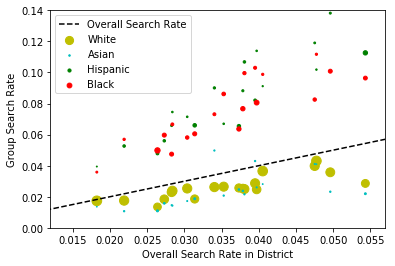

In [23]:
# plot the overall rate
plt.plot(np.linspace(0, 0.45, 10), np.linspace(0, 0.45, 10), 'k--', label = 'Overall Search Rate')

# plot the racial data
plt.scatter(x = ByRace.get_group('White').Overall_search_rate, y = ByRace.get_group('White').search_rate,
            label = 'White', c = 'y', s = pd.to_numeric(ByRace.get_group('White').n_stops / tot_stops) * 100)
plt.scatter(x = ByRace.get_group('Asian').Overall_search_rate, y = ByRace.get_group('Asian').search_rate,
            label = 'Asian', c = 'c', s = pd.to_numeric(ByRace.get_group('Asian').n_stops / tot_stops) * 100)
plt.scatter(x = ByRace.get_group('Hispanic').Overall_search_rate, y = ByRace.get_group('Hispanic').search_rate,
            label = 'Hispanic', c = 'g', s = pd.to_numeric(ByRace.get_group('Hispanic').n_stops / tot_stops) * 100)
plt.scatter(x = ByRace.get_group('Black').Overall_search_rate, y = ByRace.get_group('Black').search_rate,
            label = 'Black', c = 'r', s = pd.to_numeric(ByRace.get_group('Black').n_stops / tot_stops) * 100)
    
# make it look good
plt.legend()
plt.xlabel('Overall Search Rate in District')
plt.ylabel('Group Search Rate')
plt.axis([0.012, .057, 0, .14]);

And now hit rate. The points are normalized based on total searches.

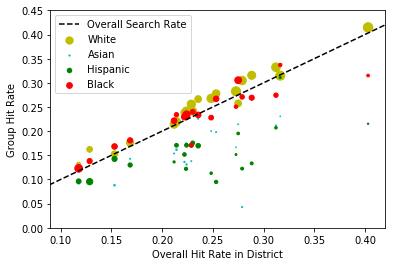

In [24]:
# plot the overall rate
plt.plot(np.linspace(0, 0.5, 10), np.linspace(0, 0.5, 10), 'k--', label = 'Overall Search Rate')


# plot the racial data
plt.scatter(x = ByRace.get_group('White').Overall_hit_rate, y = ByRace.get_group('White').hit_rate,
            label = 'White',c = 'y', s = pd.to_numeric(ByRace.get_group('White').n_searches / tot_searches) * 100)
plt.scatter(x = ByRace.get_group('Asian').Overall_hit_rate, y = ByRace.get_group('Asian').hit_rate,
            label = 'Asian', c = 'c', s = pd.to_numeric(ByRace.get_group('Asian').n_searches / tot_searches) * 100)
plt.scatter(x = ByRace.get_group('Hispanic').Overall_hit_rate, y = ByRace.get_group('Hispanic').hit_rate,
            label='Hispanic', c = 'g', s = pd.to_numeric(ByRace.get_group('Hispanic').n_searches / tot_searches) * 100)
plt.scatter(x = ByRace.get_group('Black').Overall_hit_rate, y = ByRace.get_group('Black').hit_rate,
            label = 'Black',c = 'r',s = pd.to_numeric(ByRace.get_group('Black').n_searches / tot_searches) * 100)

# make it look better
plt.legend()
plt.xlabel('Overall Hit Rate in District')
plt.ylabel('Group Hit Rate')
plt.axis([0.09, .42, 0, .45]);

And finally, let's visualize the relative search rate (search rate / overall search rate) vs the relative hit rate (hit rate / overall hit rate). Point sizes represent the number of hits.

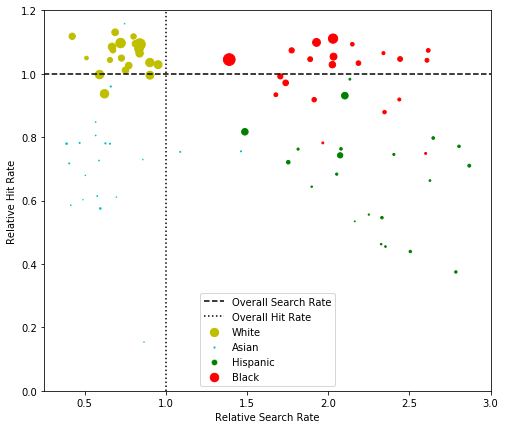

In [25]:
# calculate relative rates
LocationStops['diff_hit_rate'] = LocationStops['hit_rate'] / LocationStops['Overall_hit_rate']
LocationStops['diff_search_rate'] = LocationStops['search_rate'] / LocationStops['Overall_search_rate']

# initialize plot
plt.figure(figsize = (8,7))

# plot overall data

plt.plot(np.linspace(0,5,10),np.ones(10),'k--',label='Overall Search Rate')
plt.plot(np.ones(10),np.linspace(0,1.5,10),'k:',label='Overall Hit Rate')

# plot actual data

plt.scatter(x = ByRace.get_group('White').diff_search_rate, y = ByRace.get_group('White').diff_hit_rate,
            label = 'White', c = 'y', s = pd.to_numeric(ByRace.get_group('White').n_hits 
                                                        / SummarizedStops.n_hits[0]) * 2000)
plt.scatter(x = ByRace.get_group('Asian').diff_search_rate, y = ByRace.get_group('Asian').diff_hit_rate,
            label = 'Asian', c = 'c', s = pd.to_numeric(ByRace.get_group('Asian').n_hits 
                                                        / SummarizedStops.n_hits[0]) * 2000)
plt.scatter(x = ByRace.get_group('Hispanic').diff_search_rate, y = ByRace.get_group('Hispanic').diff_hit_rate,
            label = 'Hispanic', c = 'g', s = pd.to_numeric(ByRace.get_group('Hispanic').n_hits 
                                                           / SummarizedStops.n_hits[0]) * 2000)
plt.scatter(x = ByRace.get_group('Black').diff_search_rate, y = ByRace.get_group('Black').diff_hit_rate,
            label = 'Black',c = 'r',s = pd.to_numeric(ByRace.get_group('Black').n_hits 
                                                / SummarizedStops.n_hits[0]) * 2000)

# make it look better
plt.legend(loc = 8)
plt.xlabel('Relative Search Rate')
plt.ylabel('Relative Hit Rate')
plt.axis([0.25, 3, 0, 1.2]);

I'll conclude by just printing out the district information. Hopefully, this notebook gives a sense of what factors affect a persons interactions with the police.

In [26]:
LocationStops

,race,district_number,n_stops,n_searches,n_hits,search_rate,Overall_search_rate,hit_rate,Overall_hit_rate,diff_hit_rate,diff_search_rate
White in 01,White,01,126922,2225,569,0.017530,0.021903,0.255730,0.228845,1.117483,0.800370
Black in 01,Black,01,8201,467,80,0.056944,0.021903,0.171306,0.228845,0.748569,2.599846
Hispanic in 01,Hispanic,01,9686,510,87,0.052653,0.021903,0.170588,0.228845,0.745431,2.403938
Asian in 01,Asian,01,2712,29,4,0.010693,0.021903,0.137931,0.228845,0.602727,0.488209
White in 02,White,02,165797,4737,769,0.028571,0.054328,0.162339,0.128637,1.261996,0.525903
Black in 02,Black,02,39585,3816,527,0.096400,0.054328,0.138103,0.128637,1.073587,1.774421
Hispanic in 02,Hispanic,02,50190,5653,540,0.112632,0.054328,0.095525,0.128637,0.742591,2.073198
Asian in 02,Asian,02,9387,206,19,0.021945,0.054328,0.092233,0.128637,0.717004,0.403942
White in 03,White,03,180546,5915,779,0.032762,0.077551,0.131699,0.117797,1.118015,0.422454
Black in 03,Black,03,201600,21731,2674,0.107793,0.077551,0.123050,0.117797,1.044592,1.389959
